In [1]:
import json
import datetime
import requests
import time
import matplotlib
matplotlib.use('nbagg')
%matplotlib inline


from ipywidgets import widgets
from IPython import display
import math
import numpy as np
import matplotlib.pyplot as plt

import math
import numpy as np

from matplotlib.ticker import FormatStrFormatter

### Read User data

In [2]:
file = open("Latest Data.txt", "r") #Currently just copy pasted from Database to .txt
json_data = json.load(file)
appliances_data = json_data['timestamps']
file.close()
times = []
x = 0
cutOffTime = 1496000000000
smallest = 1000000000000000000000
tst = ""
for value in appliances_data:
    for val in appliances_data[value]:
        if val[0] > cutOffTime:
            times.append(val[0])
                        
times.sort()
start = times[0] #records first and last timestamp inputted
end = times[-1]

appliances_data.keys()[0:5]

[u'Kitchen cabinet lights',
 u'Master Closet Leon',
 u'Master Bedroom Lights',
 u'Katya Bathroom Light',
 u'Masha Desk Light']

### eyedro API reading

In [3]:
def httpGet(startTime, endTime): #Pulling data from API
    f = open('eyedro_cred.txt', 'r')
    baseURL = f.readline()[:-1]
    UserKey = f.readline()
    cmd = "VostroEnergy.GetData"
    fullURL = str(baseURL) + "UserKey=" + str(UserKey) + "&Cmd=" + str(cmd) + "&DateStartSecUtc=" + str(startTime) + "&DateStopSecUtc=" + str(endTime)
    print(fullURL)
    response = requests.get(fullURL).json()
    return response

apiJSON = httpGet(int(round(start/1000)),int(round(end/1000)) + 10)


apiList = apiJSON["Data"]["004006EE"]
apiList[0:5]

https://api.eyedro.com/e2?UserKey=vostro3ryV2x4jhewPhLN6UQRtxZ35vXqGamTauq&Cmd=VostroEnergy.GetData&DateStartSecUtc=1496145411&DateStopSecUtc=1496147372


[[1496145411, 1084],
 [1496145585, 556],
 [1496145629, 556],
 [1496145700, 809],
 [1496145929, 809]]

## write to CSV

In [4]:
# apiFile = open("apiRawData.csv","w") #Writes Data from API between start and stop times
# apiFile.write("Timestamp,Power,\n")
# for value in apiList:
# 	apiFile.write(str(value[0]) + "," + str(value[1]) + ",\n")
# apiFile.close()

# usrFile = open("usrRawData.csv","w")
# usrFile.write("Appliance,Timestamp,State(On/Off),\n")
# for value in timestamps:
#     for val in timestamps[value]:
#         usrFile.write(str(value) + "," + str(val[0]) + "," + str(val[1]) + ",\n")
# usrFile.close()

### reformatting for comparison with API data

In [5]:
reformattedUsrList = []
testList = ["Back yard lights", "Garage Lights", "Master Bath Vanity", "Toaster", "Kitchen Hood"]
for value in appliances_data:
    for val in appliances_data[value]:
        if val[0] > cutOffTime:
            times.append(val[0])
            tempVal = []
            tempVal.append(value)
            tempVal += val
            reformattedUsrList.append(tempVal)
            
reformattedUsrList.sort(key=lambda x: x[1])
reformattedUsrList[0:10]

[[u'Master Closet Leon', 1496145411199, 1],
 [u'Master Bath Vanity', 1496145702721, 1],
 [u'Master Bath Vanity', 1496146081591, 0],
 [u'Master Bath Vanity', 1496146084760, 0],
 [u'Master Closet Leon', 1496146113720, 0],
 [u'Master Closet Leon', 1496146134735, 1],
 [u'Master Closet Leon', 1496146249349, 0],
 [u'Back yard lights', 1496146360005, 1],
 [u'Back yard lights', 1496146372287, 0],
 [u'Back yard lights', 1496146405409, 1]]

### Matching the API data and User clicks

In [6]:
matches = {}
nMatches = 0
precision = 5 #Careful raising this too high.
for usrVal in reformattedUsrList:
    try:
        matches[usrVal[0]]
    except KeyError:
        matches[usrVal[0]] = []
    for apiVal in apiList:
        if abs(usrVal[1]/1000 - (apiVal[0] + 3)) < precision: #The "+3" Is because I noticed the api data tended to be off by about 3 seconds on average
            match = [round(usrVal[1]/1000), usrVal[2], apiVal[0], apiVal[1]] #inner Data is [usr-ts, on/off, api-ts, power]
            matches[usrVal[0]].append(match)
            nMatches += 1
            
"""for value in matches:
    if matches[value] != []:
        print(value, ": ", matches[value])"""

print("Matches:",nMatches)
print("Match precision: +/-", precision, "seconds")

matches['Toaster']

('Matches:', 30)
('Match precision: +/-', 5, 'seconds')


[[1496146977.0, 1, 1496146971, 2541], [1496146977.0, 1, 1496146974, 2493]]

### Presenting matches

In [7]:
#Finding the actual wattage change for each match found
#This cell should only be run after the previous cell, otherwise a lot of redundant data will be appended each time
apiTimestamps = []
for value in apiList:
    apiTimestamps.append(value[0])
for appliance in matches:
    for value in matches[appliance]:
        ind = apiTimestamps.index(value[2])
        wChange = apiList[ind][1] - apiList[ind-1][1]
        value += [wChange]
        value += [apiList[ind][1]]
        
#Verbose output of matches
for appliance in matches:
    for value in matches[appliance]:
        print("Name: '" + str(appliance) + "'," + " usrTS: " + str((value[0] - start/1000)) + ", apiTS: " + str(value[2]) + ", On/Off: " + str(value[1]) + ", Change: " + str(value[4]) + " Watts, " + "Wattage: " + str(value[5]))

Name: 'Master Closet Leon', usrTS: 0.0, apiTS: 1496145411, On/Off: 1, Change: -224 Watts, Wattage: 1084
Name: 'Toaster', usrTS: 1566.0, apiTS: 1496146971, On/Off: 1, Change: 931 Watts, Wattage: 2541
Name: 'Toaster', usrTS: 1566.0, apiTS: 1496146974, On/Off: 1, Change: -48 Watts, Wattage: 2493
Name: 'Back yard lights', usrTS: 949.0, apiTS: 1496146358, On/Off: 1, Change: 340 Watts, Wattage: 788
Name: 'Back yard lights', usrTS: 961.0, apiTS: 1496146369, On/Off: 0, Change: -340 Watts, Wattage: 448
Name: 'Back yard lights', usrTS: 994.0, apiTS: 1496146403, On/Off: 1, Change: 345 Watts, Wattage: 793
Name: 'Back yard lights', usrTS: 1013.0, apiTS: 1496146420, On/Off: 0, Change: -345 Watts, Wattage: 448
Name: 'Back yard lights', usrTS: 1022.0, apiTS: 1496146429, On/Off: 1, Change: 338 Watts, Wattage: 786
Name: 'Back yard lights', usrTS: 1038.0, apiTS: 1496146445, On/Off: 0, Change: -339 Watts, Wattage: 447
Name: 'Back yard lights', usrTS: 1360.0, apiTS: 1496146771, On/Off: 0, Change: 340 Watts

### Outputting matches{} to a CSV

In [8]:

# matchFile = open("matches.csv","w")

# matchFile.write("Appliance Name,User Timestamp,API Timestamp,State (On/Off),Power Change(W),\n")
# for appliance in matches:
#     for value in matches[appliance]:
#         matchFile.write(str(appliance) + "," + str(value[0]) + "," + str(value[2]) + "," + str(value[1]) + "," + str(value[4]) + "\n")
        
# matchFile.close()

### Visualizing ApiList

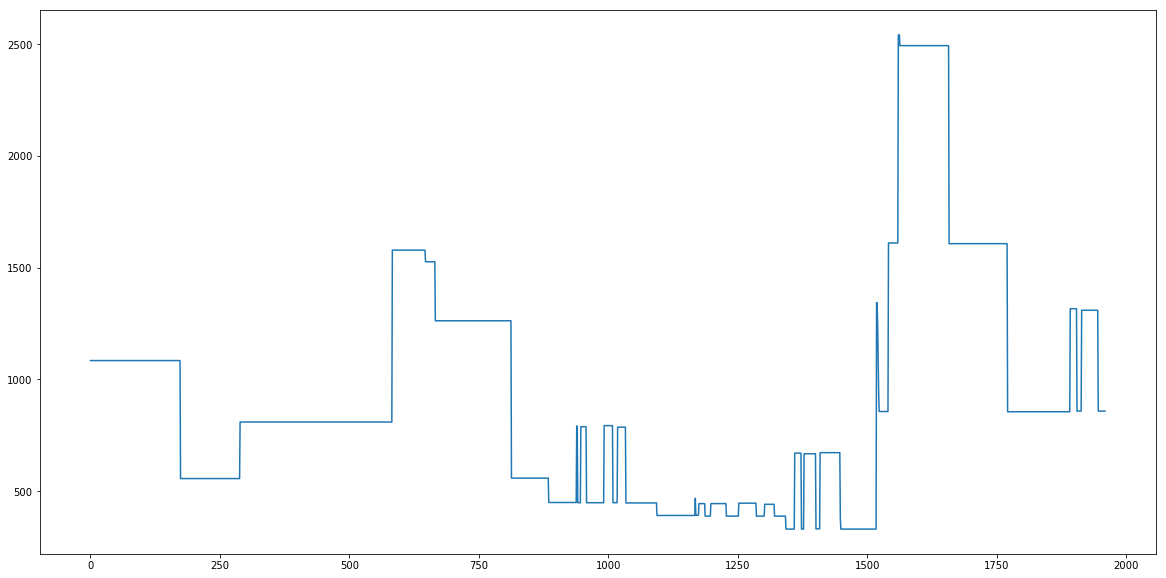

In [9]:
fig = plt.figure(figsize = (20,10))

x = []
y = []

start = apiList[0][0]
end = apiList[-1][0]

cPos = 0
lastY = apiList[0][1]
apiTS = 0
    
for time in range(int(math.floor(end - start))):
    if apiTS == time:
        lastY = apiList[cPos][1]
        cPos += 1
        apiTS = math.floor(apiList[cPos][0] - start)
        y.append(lastY)
        x.append(time)
    else:
        y.append(lastY)
        x.append(time)

plt.plot(x,y)

fullVals = []

for i in range((reformattedUsrList[-1][1] - reformattedUsrList[0][1])/1000):
    fullVals.append([x[i],y[i]])

### Visualization of appliance range

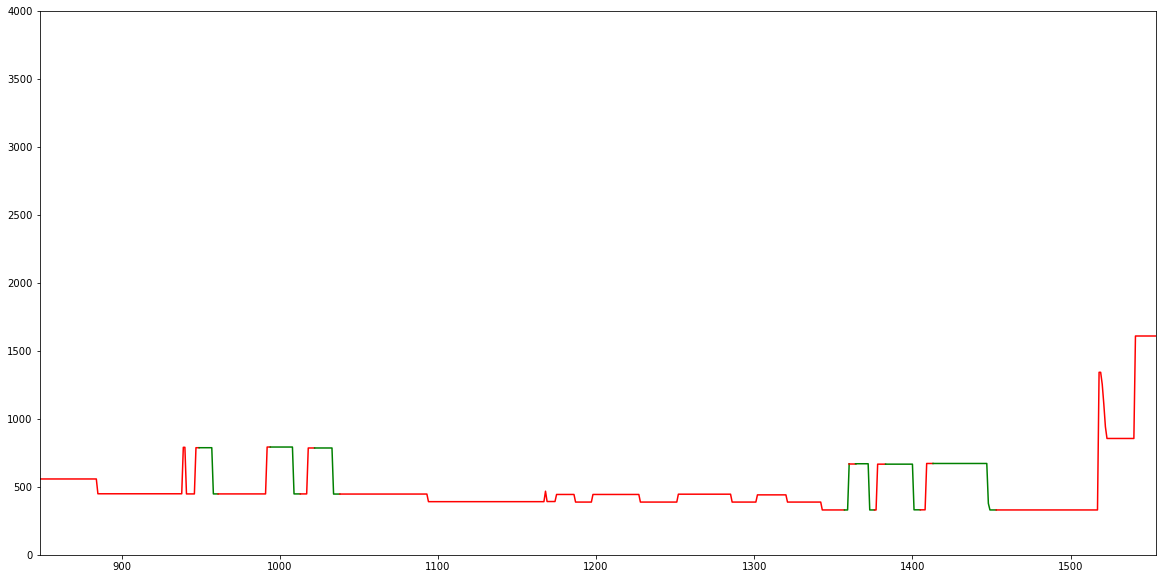

In [10]:

usrData = reformattedUsrList
sorted(usrData, key=lambda x: x[0])
global fullRange
global counter
global stateLength
stateLength = 0
counter = 0
fullRange = True


fig_size = plt.rcParams["figure.figsize"]

tList = []

applianceList = []
for value in usrData:
    if value[0] not in applianceList:
        applianceList.append(value[0])

applianceList.sort()     

#Initializing and configuring the widgets in the output
w = widgets.Dropdown(
    options = applianceList,
    value = applianceList[0],
    description = "Appliances:"
)

b = widgets.Button(description='Update Graph')
b2 = widgets.Button(description='Toggle Full Range')

display.display(w)
display.display(b)
display.display(b2)

x2 = []
y2 = []

start = apiList[0][0]
end = apiList[-1][0]

cPos = 0
lastY = apiList[0][1]
apiTS = 0

#Generating x and y data for the graphs below    
for time in range(int(math.floor(end - start))):
    if apiTS == time:
        lastY = apiList[cPos][1]
        cPos += 1
        apiTS = math.floor(apiList[cPos][0] - start)
        y2.append(lastY)
        x2.append(time)
    else:
        y2.append(lastY)
        x2.append(time)
        
        
#Changing the graph's color depending on if the appliance was on or off
def color(onOff, adjustedTList, ts):
    newL = []
    for i in range(len(onOff)): #New list holding On/Off transitions as well as corresponding timestamps
        newL.append([onOff[i], adjustedTList])
    temp = []
    for value in adjustedTList:
        temp.append([value,0])
    temp.append([ts, 1]) 
    temp2 = []
    #Ineficient algorithm which sorts an array by the 2nd index.
    #Made because I was having issues with the built in algorithm at the time
    for i in range(len(temp)): 
        placed = False
        if len(temp2) == 0:
            temp2.append([temp[i][0],temp[i][1]])
        else:
            for j in range(len(temp2)):
                if temp[i][0] > temp2[j][0]:
                    if j == len(temp2) - 1:
                        temp2.insert(j + 1, [temp[i][0],temp[i][1]])
                elif temp[i][0] < temp2[j][0]:
                    if placed:
                        None
                    else:   
                        placed = True
                        temp2.insert(j, [temp[i][0],temp[i][1]])
                elif temp[i][0] == temp2[j][0]:
                    if placed:
                        None
                    else:
                        placed = True
                        temp2.insert(j, [temp[i][0],temp[i][1]])
    temp = temp2
    index = 0
    for i in range(len(temp)):
        if temp[i][1] == 1:
            index = i
    if index == 0: #If the current index is 0, the appliance is not currently on. Set the graph to red
        return "red"
    elif index == len(newL): #if the index is equal to the length of onOff then it's the last value; assume he forgot to turn off
        return "red"
    else:
        if newL[index-1][0] == 0:
            return "red"
        else:
            return "green"
        
#Function called whenever "Update Graph is pressed. Changes the colors of the graph to represent the
#new appliance of interest.
def onButtonClick(b):
    global stateLength
    tList = []
    adjustedTList = []
    onOff = []
    tempL = []
    for value in usrData:
        if value[0].lower() == w.value.lower():
            tempL.append(value)
    sorted(tempL, key=lambda x: x[1])
    for value in tempL:
        tList.append(value[1])
        onOff.append(value[2])
        
    for value in tList:
        tVal = (value/1000 - start)
        adjustedTList.append(tVal)
    
    adjustedTList.sort()
    previousVal = 0
    stateLength = len(onOff)
    xi = adjustedTList[0]
    xf = adjustedTList[-1]
    r = xf - xi
    fig_size[0],fig_size[1] = 20,10
    for value in adjustedTList:
        plt.plot(x2[int(previousVal):int(value + 1)], y2[int(previousVal):value + 1], color = color(onOff, adjustedTList, value))
        logs = (onOff, adjustedTList, value)
        display.clear_output(wait=True)
        previousVal = value
    plt.plot(x2[int(adjustedTList[-1]):-1], y2[int(adjustedTList[-1]):-1], color = "red")
    fig_size[0],fig_size[1] = 20,10
    if fullRange:
        None
    else:   
        plt.axis([xi - 0.2 * r, xf + 0.2 * r,0,4000])
    plt.show()
    
#Changes the range of the graph to zoom in on the time period where the chosen appliance is turned on and off
def toggleRange(b2):
    global fullRange
    if fullRange:
        fullRange = False
    else:
        fullRange = True
    onButtonClick(b)
        
b.on_click(onButtonClick)
b2.on_click(toggleRange)

### Visualizing user timestamps with API graph

In [12]:
text = widgets.Text()

x = []
y = []

cPos = 0
lastY = apiList[0][1]
apiTS = 0

#Sorting and reformatting the data once again for ease of processing
temp = []
for value in reformattedUsrList:
    temp.append(value[1])
temp.sort()
reformattedAgain = []
initialTS = temp[0]
for value in reformattedUsrList:
    #The "-5" on the following line is a simple fix for the slightly misplaced points
    reformattedAgain.append([value[0],(int(value[1])-initialTS)/1000, value[2]])
reformattedAgain.sort(key=lambda x: x[1])

start = apiList[0][0]
end = apiList[-1][0]

t = []

#Generating x and y axis data for the output graph
for time in range(int(math.floor(end - start))):
    if apiTS == time:
        lastY = apiList[cPos][1]
        t.append([apiList[cPos][0] - start, apiList[cPos][1]])
        cPos += 1
        apiTS = math.floor(apiList[cPos][0] - start)
        y.append(lastY)
        x.append(time)
    else:
        y.append(lastY)
        x.append(time)
        
#Generates a graph of the selected range when the user enter's a range in the text box
def handle_submit(sender):
    val = text.value
    nums = [int(n) for n in val.split(',')]
    x1 = int(nums[0])
    x2 = int(nums[1])
    display.clear_output(wait=True)
    newDomain = [x[int(nums[0]):int(nums[1])]]
    newRange = [y[int(nums[0]):int(nums[1])]]
    fig = plt.figure(figsize = (20,10))
    ax = plt.subplot(111)
    newXs = []
    newYs = []
    redXs = []
    redYs = []
    for value in reformattedAgain:
        if value[1] < nums[1] and value[1] > nums[0]:
            if value[2] == 1:
                ax.annotate(str(value[0] + " On"), [int(value[1] - 6), y[value[1] - 6]], fontsize = 12, rotation = 90)
                newXs.append(int(value[1] - 6))
                newYs.append(int(y[value[1] - 6]))
            if value[2] == 0:
                redXs.append(int(value[1] - 6))
                redYs.append(int(y[value[1] - 6]))
    ax.scatter(newXs, newYs, color = 'green')
    ax.scatter(redXs, redYs, color = 'red')
    ax.plot(x[x1:x2], y[x1:x2])
    plt.show()
    
#plt.plot(x,y)
display.display(text)
text.on_submit(handle_submit)

### Zeroing Appliance Power Data

In [47]:
%matplotlib inline

import pickle
from ipywidgets import widgets
from IPython import display
import math
import numpy as np
import matplotlib.pyplot as plt

relevant = {"Back yard lights": [], "Garage Lights":[], "Toaster":[], "Kitchen Hood":[]}
relevantGraphs = {}
closestChange = []
relevantAPI = []
fullRelevantAPI = []
perAppData = {}

#Initializing the closestChange list, note the "None" values
for value in reformattedAgain: #reformattedAgain has format: [[AppID, userTS, On/Off],[...]]
    if str(value[0]) in relevant.keys():
        relevant[str(value[0])].append([value[1],value[2]])
        closestChange.append([value[1], None, value[2], None, str(value[0])]) #[[userTS, None, On/Off, None, AppID],]

for v in relevant.keys():#initializing empty lists in for each key in relevantGraphs
    relevantGraphs[v] = []
    perAppData[v] = []
    
newS = closestChange[0][0] #this is the first UserTS
newE = closestChange[-1][0] #this is the last UserTS

#Seperating the api values which are relevant to the appliances of interest
for value in apiList:
    closest = 100
    index = 0
    adjV = (value[0] - apiList[0][0]) #adjusted API TS values, starting at TS1 = 0
    if adjV > newS - 2 and adjV < newE:
        relevantAPI.append([adjV,value[1]]) #relevant API only has values between the range of usr timestamps
    fullRelevantAPI.append([adjV,value[1]])
            
#Matching user data with closest API timestamps
for i in range(len(closestChange)):
    closest = 100 #arbitrary starting value for closest, just has to be relatively high
    index = 0
    for j in range(len(relevantAPI)):
        #if the new value being tried is closer than the previous closest, replace closest with it
        if abs(relevantAPI[j][0] - closestChange[i][0]) < abs(closest - closestChange[i][0]):
            index = j
            closest = relevantAPI[j][0]
    #make sure that the apiTS that is recognized as the closest happens before the userTS; this is the trend
    while closest - closestChange[i][0] >= 0:
        index -= 1
        closest = relevantAPI[index][0]
    newIndex = index
    
    closestChange[i][1] = closest
    closestChange[i][3] = relevantAPI[index][1] #format: [[userTS, closestAPITS, On/Off, W Chng, AppID], [...]]
    
alsoClose = []
    
for value in closestChange: #contains the single closest value
    for val in relevantAPI: #contains all of the API values
        diff = val[0] - value[1]
        if abs(diff) < 5 and diff != 0:
            if val[0] not in alsoClose:
                alsoClose.append([value[0], val[0], value[2], val[1], value[4]])
                                
closestChange += alsoClose
closestChange = sorted(closestChange, key=lambda x: int(x[1]))
                
for value in perAppData.keys():
    for val in closestChange:
        if val[4] == value:
            perAppData[value].append(val[0:-1])
                                        
start = 0
end = reformattedAgain[-1][1]
                
apiTS = []
apiW = []
goodFull = []
for value in apiList:
    apiTS.append(value[0] - apiList[0][0])
    apiW.append(value[1])
    
for t in range(newE):
    if t in apiTS:
        cv = apiW[apiTS.index(t)]
    goodFull.append([t, cv])
            
#Generating a zeroed graph for the selected appliance
for value in perAppData:
    state = 0
    apiInd = 0
    ind = 0
    cVal = 0
    apiInd = 0
    for i in range(len(relevantAPI)):
        if relevantAPI[i][0] == perAppData[value][0][1]:
            ts1 = relevantAPI[i-1][0]
            apiInd = i
            break
    for t in range(end):
        if ind < len(perAppData[value]) and state == 0:
            if t == perAppData[value][ind][1]: #check if there is a wattage change at timestamp t
                while t == perAppData[value][ind][1]: 
                    #if it is the first index it can't check the previous for change.
                    #Another method is used in this case
                    if ind == 0: 
                        ts = perAppData[value][ind][1]
                        for val in fullRelevantAPI:
                            if val[0] == ts:
                                index = fullRelevantAPI.index(val)
                                while fullRelevantAPI[index][0] - fullRelevantAPI[index - 1][0] < 10:
                                    index -= 1
                                break
                        cVal = perAppData[value][ind][3] - fullRelevantAPI[index - 1][1]
                    else: #Otherwise, simply find the change by subtracting from the previous wattage reading
                        cVal = perAppData[value][ind][3] - perAppData[value][ind-1][3]
                    state = perAppData[value][ind][2]
                    ind += 1
                    if ind == len(perAppData[value]): #If there are no more appliance state changes leave loop
                        break
        if state == 0: #If no appliance is currently turned on (according to Usr), current zeroed value is 0
            cVal = 0
            if cVal < 0:
                cVal = 0
            relevantGraphs[value].append([t, cVal])
        if state == 1: #If an appliance is currently turned on
            if t == perAppData[value][ind][1]: #If a wattage changed occured at timestamp t
                while t == perAppData[value][ind][1]: #this checks for multiple consecutive wattage changes
                    state = perAppData[value][ind][2] #Changes the state to the new app state
                    if state == 0: #if the new state is 0, nothing is on so set the value to 0
                        cVal = 0
                    else: #if the new state is still 1, set the change the value to the new W change
                        cVal += perAppData[value][ind][3] - perAppData[value][ind-1][3]
                    ind += 1
                    if ind == len(perAppData[value]): #If there are no more appliance state changes leave loop
                        break
            if cVal < 0: #If the current value ever goes negative, something is wrong and set it to 0
                cVal = 0
            relevantGraphs[value].append([t, cVal])   
        
appL = []

#Adding relevant appliances to the drop down menu
for value in relevantGraphs:
    if value not in appL:
        appL.append(value)
        
b = widgets.Button(description='Update Graph')
w = widgets.Dropdown(
    options = appL,
    value = appL[0],
    description = "Apps:"
)

display.display(w)
display.display(b)

global pickled
pickled = False

#Displaying the zeroed graph for the selected appliance
def buttonClick(b):
    x = []
    y = []
    for val in relevantGraphs[w.value]: #w is the dropdown widget; displays only the currently selected appl.
        x.append(val[0]) #setting x axis
        y.append(val[1]) #setting y axis
    plt.plot(x,y) #plotting using matplotlib
    xi = 0
    xf = 0
    e = 0
    ymax = 0
    for i in range(len(y)):#involved in setting xmin
        if y[i] != 0:
            xi = i
            break
    for j in range(len(y)):#involved in setting xmax
        if y[j] == 0:
            e += 1
        else:
            e = 0
    ymax = max(y)
    r = len(y) - xi - e
    plt.axis([xi - 0.2 * r , 1960 - 0.9*round(e),0,ymax *1.1]) #setting the range here in a really roundabout way.
    display.clear_output(wait=True)
    global pickled
    if not pickled: #Saving the relevant graphs data the first time the code block is executed
        save_obj(relevantGraphs, 'disaggregatedSignals')
        pickled = True
        
b.on_click(buttonClick)

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [48]:
d = load_obj('disaggregatedSignals') #Loading the saved RelevantGraphs data as "d"
d.keys()

['Back yard lights', 'Toaster', 'Kitchen Hood', 'Garage Lights']

In [49]:
print d.keys() #the disaggregated signals. Contains keys: 'Back yard lights', 'Toaster', 'Kitchen Hood', 'Garage Lights'
fullVals[0:10] #the full data. Simple list of form [[TS1, W1],[TS2, W2]...]

['Back yard lights', 'Toaster', 'Kitchen Hood', 'Garage Lights']


[[0, 1084],
 [1, 1084],
 [2, 1084],
 [3, 1084],
 [4, 1084],
 [5, 1084],
 [6, 1084],
 [7, 1084],
 [8, 1084],
 [9, 1084]]

In [67]:
from copy import deepcopy
unknown = deepcopy(goodFull)
fullVals = deepcopy(goodFull)
for value in d:
    for i in range(len(d[value])):
        if d[value][i][1] != 0:
            unknown[i][1] = unknown[i][1] - d[value][i][1]

In [51]:
len(fullVals)

1951

In [52]:
len(d['Back yard lights'])

1951

In [53]:
cc = d['Back yard lights']

### All of the tests below are performed with the "goodFull" list. I made this new list just to double check that fullVals was created properly

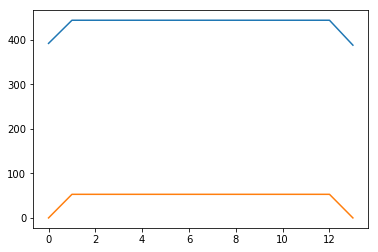

In [60]:
plt.plot(np.asarray(goodFull)[1174:1188,1])
plt.plot(np.asarray(d[d.keys()[3]])[1174:1188,1])

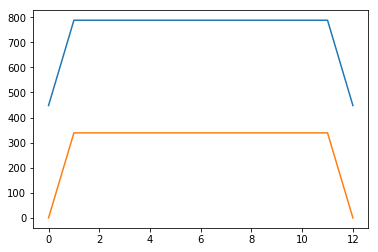

In [61]:
plt.plot(np.asarray(goodFull)[946:959,1])
plt.plot(np.asarray(d[d.keys()[0]])[946:959,1])

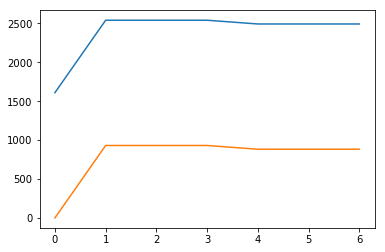

In [62]:
plt.plot(np.asarray(goodFull)[1559:1566,1])
plt.plot(np.asarray(d[d.keys()[1]])[1559:1566,1])

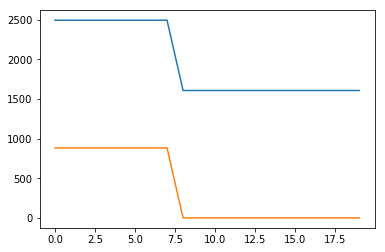

In [63]:
plt.plot(np.asarray(goodFull)[1650:1670,1])
plt.plot(np.asarray(d[d.keys()[1]])[1650:1670,1])

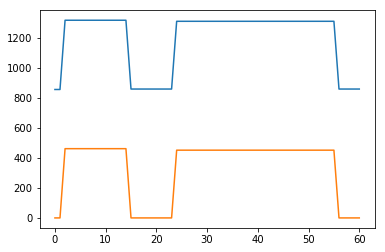

In [64]:
plt.plot(np.asarray(goodFull)[1890:2000,1])
plt.plot(np.asarray(d[d.keys()[2]])[1890:2000,1])

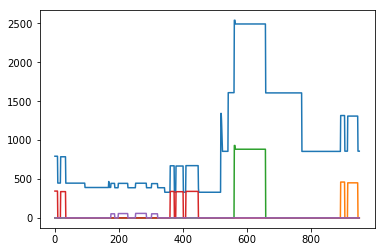

In [65]:
plt.plot(np.asarray(goodFull)[1000:2000,1])
plt.plot(np.asarray(d[d.keys()[2]])[1000:2000,1])
plt.plot(np.asarray(d[d.keys()[1]])[1000:2000,1])
plt.plot(np.asarray(d[d.keys()[0]])[1000:2000,1])
plt.plot(np.asarray(d[d.keys()[3]])[1000:2000,1])

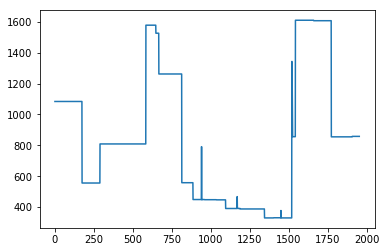

In [66]:
plt.plot(np.asarray(unknown)[0:2000,1])

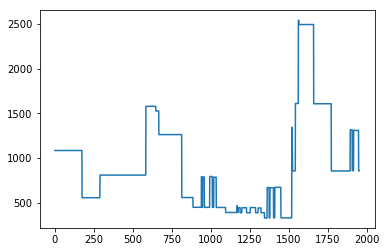

In [59]:
plt.plot(np.asarray(goodFull)[0:2000,1])

In [ ]:
meters = d.keys()
unknowun = np.zeros(len(fullVals),dtype=float)
for i,meter in enumerate(meters):
    power_series = np.array(d[meter] , dtype=float)
    unknowun = unknowun + power_series[:,1]

In [ ]:
num_states_dict={}
for i,meter in enumerate(meters):
    num_states_dict[meter] = 2

In [ ]:
learnt_model={}
from hmmlearn import hmm
for i,meter in enumerate(meters):
    power_series = np.array(d[meter] , dtype=float)
    meter_data = power_series[:,1]
    X = meter_data.reshape((-1, 1))
    num_total_states = num_states_dict.get(meter)
    
    print("Training model for submeter '{}'".format(meter))
    learnt_model[meter] = hmm.GaussianHMM(num_total_states, "full")

    # Fit
    learnt_model[meter].fit(X)


In [ ]:
learnt_model

In [ ]:
from copy import deepcopy
import itertools
def sort_startprob(mapping, startprob):
    """ Sort the startprob according to power means; as returned by mapping
    """
    num_elements = len(startprob)
    new_startprob = np.zeros(num_elements)
    for i in range(len(startprob)):
        new_startprob[i] = startprob[mapping[i]]
    return new_startprob


def sort_covars(mapping, covars):
    new_covars = np.zeros_like(covars)
    for i in range(len(covars)):
        new_covars[i] = covars[mapping[i]]
    return new_covars


def sort_transition_matrix(mapping, A):
    """Sorts the transition matrix according to increasing order of
    power means; as returned by mapping

    Parameters
    ----------
    mapping :
    A : numpy.array of shape (k, k)
        transition matrix
    """
    num_elements = len(A)
    A_new = np.zeros((num_elements, num_elements))
    for i in range(num_elements):
        for j in range(num_elements):
            A_new[i, j] = A[mapping[i], mapping[j]]
    return A_new

def return_sorting_mapping(means):
    means_copy = deepcopy(means)
    means_copy = np.sort(means_copy, axis=0)

    # Finding mapping
    mapping = {}
    for i, val in enumerate(means_copy):
        mapping[i] = np.where(val == means)[0][0]
    return mapping

def sort_learnt_parameters(startprob, means, covars, transmat):
    mapping = return_sorting_mapping(means)
    means_new = np.sort(means, axis=0)
    startprob_new = sort_startprob(mapping, startprob)
    covars_new = sort_covars(mapping, covars)
    transmat_new = sort_transition_matrix(mapping, transmat)
    assert np.shape(means_new) == np.shape(means)
    assert np.shape(startprob_new) == np.shape(startprob)
    assert np.shape(transmat_new) == np.shape(transmat)

    return [startprob_new, means_new, covars_new, transmat_new]


def compute_A_fhmm(list_A):
    """
    Parameters
    -----------
    list_pi : List of PI's of individual learnt HMMs

    Returns
    --------
    result : Combined Pi for the FHMM
    """
    result = list_A[0]
    for i in range(len(list_A) - 1):
        result = np.kron(result, list_A[i + 1])
    return result


def compute_means_fhmm(list_means):
    """
    Returns
    -------
    [mu, cov]
    """
    states_combination = list(itertools.product(*list_means))
    num_combinations = len(states_combination)
    means_stacked = np.array([sum(x) for x in states_combination])
    means = np.reshape(means_stacked, (num_combinations, 1))
    cov = np.tile(5 * np.identity(1), (num_combinations, 1, 1))
    return [means, cov]


def compute_pi_fhmm(list_pi):
    """
    Parameters
    -----------
    list_pi : List of PI's of individual learnt HMMs

    Returns
    -------
    result : Combined Pi for the FHMM
    """
    result = list_pi[0]
    for i in range(len(list_pi) - 1):
        result = np.kron(result, list_pi[i + 1])
    return result

def create_combined_hmm(models):
    list_pi = [models[appliance].startprob_ for appliance in models]
    list_A = [models[appliance].transmat_ for appliance in models]
    list_means = [models[appliance].means_.flatten().tolist() for appliance in models]

    pi_combined = compute_pi_fhmm(list_pi)
    A_combined = compute_A_fhmm(list_A)
    [mean_combined, cov_combined] = compute_means_fhmm(list_means)

    combined_model = hmm.GaussianHMM(n_components=len(pi_combined), covariance_type='full')
    combined_model.startprob_ = pi_combined
    combined_model.transmat_ =A_combined
    combined_model.covars_ = cov_combined
    combined_model.means_ = mean_combined
    return combined_model

In [ ]:
m1 = learnt_model[learnt_model.keys()[0]]
m1

In [ ]:
m1.means_

In [ ]:
return_sorting_mapping(m1.means_)

In [ ]:
startprob, means, covars, transmat = sort_learnt_parameters( m1.startprob_, m1.means_,m1.covars_, m1.transmat_)

In [ ]:
from collections import OrderedDict
# Combining to make a AFHMM
self_meters = []
new_learnt_models = OrderedDict()
for meter in learnt_model:
    startprob, means, covars, transmat = sort_learnt_parameters(
        learnt_model[meter].startprob_, learnt_model[meter].means_,
        learnt_model[meter].covars_, learnt_model[meter].transmat_)
    new_learnt_models[meter] = hmm.GaussianHMM(startprob.size, "full")
    new_learnt_models[meter].transmat_ =  transmat
    new_learnt_models[meter].startprob_ = startprob
    new_learnt_models[meter].means_ = means
    new_learnt_models[meter].covars_ = covars
#     # UGLY! But works.
    self_meters.append(meter)

learnt_model_combined = create_combined_hmm(new_learnt_models)
self_individual = new_learnt_models
self_model = learnt_model_combined
self_model

In [ ]:

power_series

In [ ]:
power_series = np.array(fullVals , dtype=float)
meter_data = power_series[:,1]
temp = meter_data.reshape((-1, 1))
temp  

In [ ]:
pred = {}
pred = learnt_model_combined.predict(temp)
pred[0:25]

In [ ]:

gt= {}
# Array of learnt states
learnt_states_array = []
learnt_states_array.append(pred)
learnt_states_array

In [ ]:
from six import iteritems
# Model
means = OrderedDict()
for elec_meter, model in iteritems(self_individual):
    means[elec_meter] = (model.means_.round().astype(int).flatten().tolist())
    means[elec_meter].sort()
means

In [ ]:
def decode_hmm(length_sequence, centroids, appliance_list, states):
    """
    Decodes the HMM state sequence
    """
    hmm_states = {}
    hmm_power = {}
    total_num_combinations = 1

    for appliance in appliance_list:
        total_num_combinations *= len(centroids[appliance])

    for appliance in appliance_list:
        hmm_states[appliance] = np.zeros(length_sequence, dtype=np.int)
        hmm_power[appliance] = np.zeros(length_sequence)

    for i in range(length_sequence):

        factor = total_num_combinations
        for appliance in appliance_list:
            # assuming integer division (will cause errors in Python 3x)
            factor = factor // len(centroids[appliance])

            temp = int(states[i]) / factor
            hmm_states[appliance][i] = temp % len(centroids[appliance])
            hmm_power[appliance][i] = centroids[
                appliance][hmm_states[appliance][i]]
    return [hmm_states, hmm_power]

In [ ]:
decoded_power_array = []
decoded_states_array = []

for learnt_states in learnt_states_array:
    [decoded_states, decoded_power] = decode_hmm(len(learnt_states), means, means.keys(), learnt_states)
    decoded_states_array.append(decoded_states)
    decoded_power_array.append(decoded_power)

In [ ]:
import pandas as pd
prediction = pd.DataFrame(decoded_power_array[0])
prediction

In [ ]:
plt.plot(prediction.iloc[0:2000])

In [ ]:
prediction.head()

In [ ]:
sumPred = prediction.sum(axis=1)

In [ ]:
plt.plot(sumPred[0:2000])

In [ ]:
plt.plot(np.asarray(fullVals)[:,1])